In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
# from torchsummary import summary
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split

In [31]:
if torch.cuda.is_available():
    print("The code will run on GPU. This is important so things run faster.")
else:
    print("The code will run on CPU. You should probably not do this.")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on CPU. You should probably not do this.


[torch.utils.data.dataset.Dataset, object]

In [51]:
data = np.load('data.npy')
target = np.load('target.npy')

train_idx,test_idx = train_test_split(np.arange(data.shape[0]),test_size=0.1)

trainset = data[train_idx]
train_y = target[train_idx]
testset = data[test_idx]
test_y = target[test_idx]

batch_size=50
    

train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=1)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=1)

In [53]:
for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
    t = 1

ValueError: too many values to unpack (expected 2)

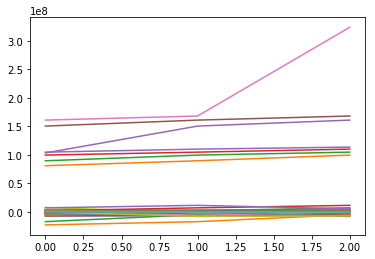

In [26]:
for i in range(100):
    plt.plot(data[i,:,1])
plt.show()

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.linearIn = nn.Sequential(nn.Linear(in_features=5,out_features=30),
                                   nn.ReLU(),
                                   nn.Linear(30,100),
                                   nn.ReLU(),
                                   nn.Linear(100,50)) 
        self.rnn = nn.LSTM(input_size=50,
                          hidden_size=100,
                          num_layers=5,
                          batch_first=True)
        self.linearOut = nn.Sequential(nn.Linear(in_features=300,out_features=500),
                                     nn.ReLU(),
                                     nn.Linear(500,250),
                                     nn.ReLU(),
                                     nn.Linear(250,100),
                                     nn.ReLU(),
                                     nn.Linear(100,25),
                                     nn.ReLU(),
                                     nn.Linear(25,2))

        
    def forward(self, x): #x = [batch_size,3,5]
        x1 = self.linearIn(x[:,0,:]) #[batch_size,50]
        x2 = self.linearIn(x[:,1,:]) #[batch_size,50]
        x3 = self.linearIn(x[:,2,:]) #[batch_size,50]
        x1 = x1.unsqueeze(1) #[batch_size,1,50]
        x2 = x2.unsqueeze(1) #[batch_size,1,50]
        x3 = x3.unsqueeze(1) #[batch_size,1,50]     
        temp = []
        temp.append(x1)
        temp.append(x2)
        temp.append(x3)
        x = torch.cat(temp,dim=1) #[batch_size,3,50]                        
                                            
        x,_ = self.rnn(x) #[batch_size,3,100]
        x = x.view(x.shape[0],-1) #[batch_size,300]
                       
        x = self.linearOut(x) #[batch_size,2]
        
        x[1] = torch.abs(x[1])

        return x


In [3]:
def cost(mu,sigma,y):
    dist = torch.distributions.normal.Normal(mu, sigma)
    return torch.mean(-dist.log_prob(y))

In [11]:
model = Net()
print(model)

Net(
  (linearIn): Sequential(
    (0): Linear(in_features=5, out_features=30, bias=True)
    (1): ReLU()
    (2): Linear(in_features=30, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=50, bias=True)
  )
  (rnn): LSTM(50, 100, num_layers=5, batch_first=True)
  (linearOut): Sequential(
    (0): Linear(in_features=300, out_features=500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=500, out_features=250, bias=True)
    (3): ReLU()
    (4): Linear(in_features=250, out_features=100, bias=True)
    (5): ReLU()
    (6): Linear(in_features=100, out_features=25, bias=True)
    (7): ReLU()
    (8): Linear(in_features=25, out_features=2, bias=True)
  )
)


In [12]:
lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=lr)

In [ ]:
#Training loop
num_epochs = 2

for epoch in tqdm(range(num_epochs), unit='epoch'):
    #For each epoch
    train_error = 0
    for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
        data, target = data.to(device), target.to(device)
        #Zero the gradients computed for each weight
        optimizer.zero_grad()
        #Forward pass your image through the network
        output = model(data)
        #Compute the loss
        loss = cost(output[0],output[1], target)
        #Backward pass through the network
        loss.backward()
        #Update the weights
        optimizer.step()
        train_error += loss
        
    #Comput the test accuracy
    test_error = 0
    for data, target in test_loader:
        data = data.to(device)
        with torch.no_grad():
            output = model(data)
        test_error += cost(output[0],output[1],target)
    train_err = train_error/len(trainset)
    test_err = test_error/len(testset)
    print("train error: {train:.1f}%\t test error: {test:.1f}%".format(test=test_err, train=train_err))